# Lasso Problems

## Libraries

In [1]:
import numpy as np
import cv2 as cv
import pywt as wt
import matplotlib.pyplot as plt

## Load resources

In [2]:
BASE_DIR = '../resources/images/lasso-problems/'
dark_sky_img = cv.cvtColor(cv.imread(f'{BASE_DIR}/dark-sky.jpg'), cv.COLOR_BGR2RGB)
print(f'The image has {dark_sky_img.shape} dimensions')

The image has (460, 700, 3) dimensions


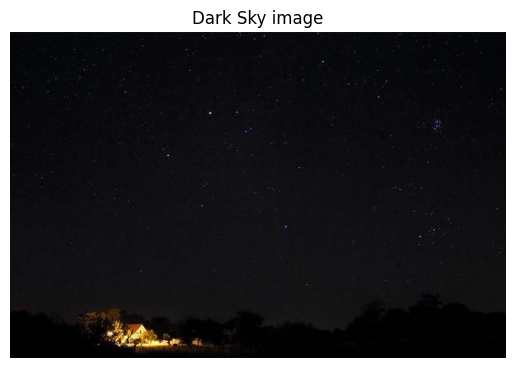

In [3]:
plt.imshow(dark_sky_img)
plt.axis('off')
plt.title('Dark Sky image')
plt.show()

## Implement ADMM algorithm

The general problem to solve is:
$$
\begin{gather}
\min_{\mathbf{x}} \Vert \mathbf{y} - \mathbf{Hx} \Vert^2_2 + \lambda \Vert \mathbf{z} \Vert_1 \\
\text{subject to: } x - z = 0
\end{gather}
$$

We use the following form:
$$
\begin{alignat}{1}
x_{k + 1} &= (H^T H + \rho I)^{-1} (H^T y + \rho z^k - \mu^k) \\
z_{k + 1} &= S_{\lambda/\rho} (x^{k+1} + \mu^k /\rho) \\
\mu_{k + 1} &= \mu_k + \rho (x^{k+1} - z^{k+1})
\end{alignat}
$$

Implement each iterator.

In [4]:
def x_k_next(img, H, rho, z_k, u_k):
    y = img
    res = np.linalg.inv(np.matmul(H.T, H) + rho * np.identity(H.shape[1]))
    res = np.matmul(res, np.matmul(H.T, y) + rho * z_k - u_k)
    return res

def z_k_next(x_k, u_k, lamb, rho):
    return wt.threshold(x_k + u_k, lamb/rho, mode='soft')

def u_k_next(u_k, rho, x_k_next, z_k_next):
    u_k_next = u_k + rho * (x_k_next - z_k_next)
    return u_k_next

Define un wrapper to use ADMM algorithm.

In [5]:
def admm_alg(img, H, lamb=0.01, rho=1, steps=10):
    height, width = img.shape
    square_init = (width, width)
    x_0 = np.ones(square_init)
    z_0 = np.ones(square_init)
    u_0 = np.ones(square_init)
    TOLERANCE = 0.000001
    
    x_hist = []
    z_hist = []
    u_hist = []

    x_k = x_0
    z_k = z_0
    u_k = u_0
    for step in range(steps):
        x_kn = x_k_next(img, H, rho, z_k, u_k)
        z_kn = z_k_next(x_k, u_k, lamb, rho)
        u_kn = u_k_next(u_k, rho, x_kn, z_kn)

        x_k = x_kn
        z_k = z_kn
        u_k = u_kn
        x_hist.append(x_k)
        z_hist.append(z_k)
        u_hist.append(u_k)

        if np.linalg.norm(x_k - x_hist[step - 1]) < TOLERANCE:
            print(f'The tolerance has reached in step {step}')
            break

    return [x_hist, z_hist, u_hist]

## Lasso method under different scenarios

The image has resized to 64x64 pixels.

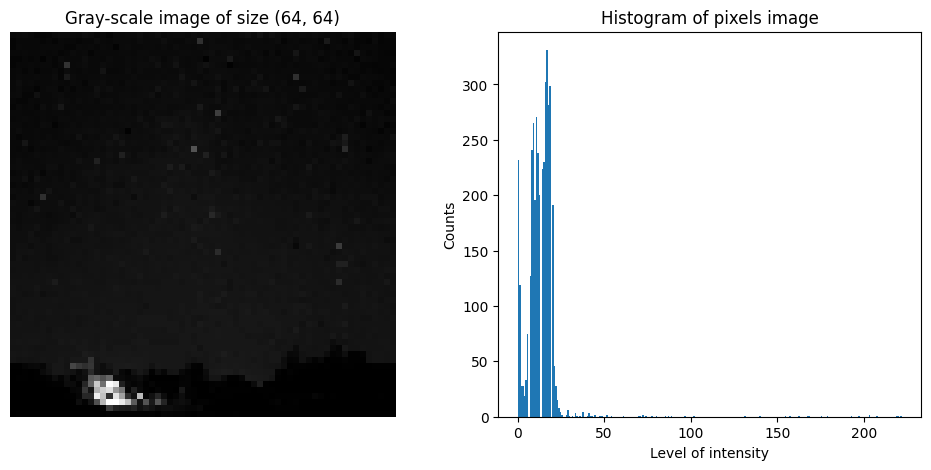

In [6]:
dark_sky_gray = cv.resize(cv.cvtColor(dark_sky_img, cv.COLOR_RGB2GRAY), (64, 64))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(dark_sky_gray, cmap='gray')
plt.title(f'Gray-scale image of size {dark_sky_gray.shape}')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.hist(dark_sky_gray.ravel(), bins=256)
plt.title('Histogram of pixels image')
plt.xlabel('Level of intensity')
plt.ylabel('Counts')
plt.show()

### Noiseless-case 

In this scenario, the noise is eliminated and results is:
$$
y = Hx
$$

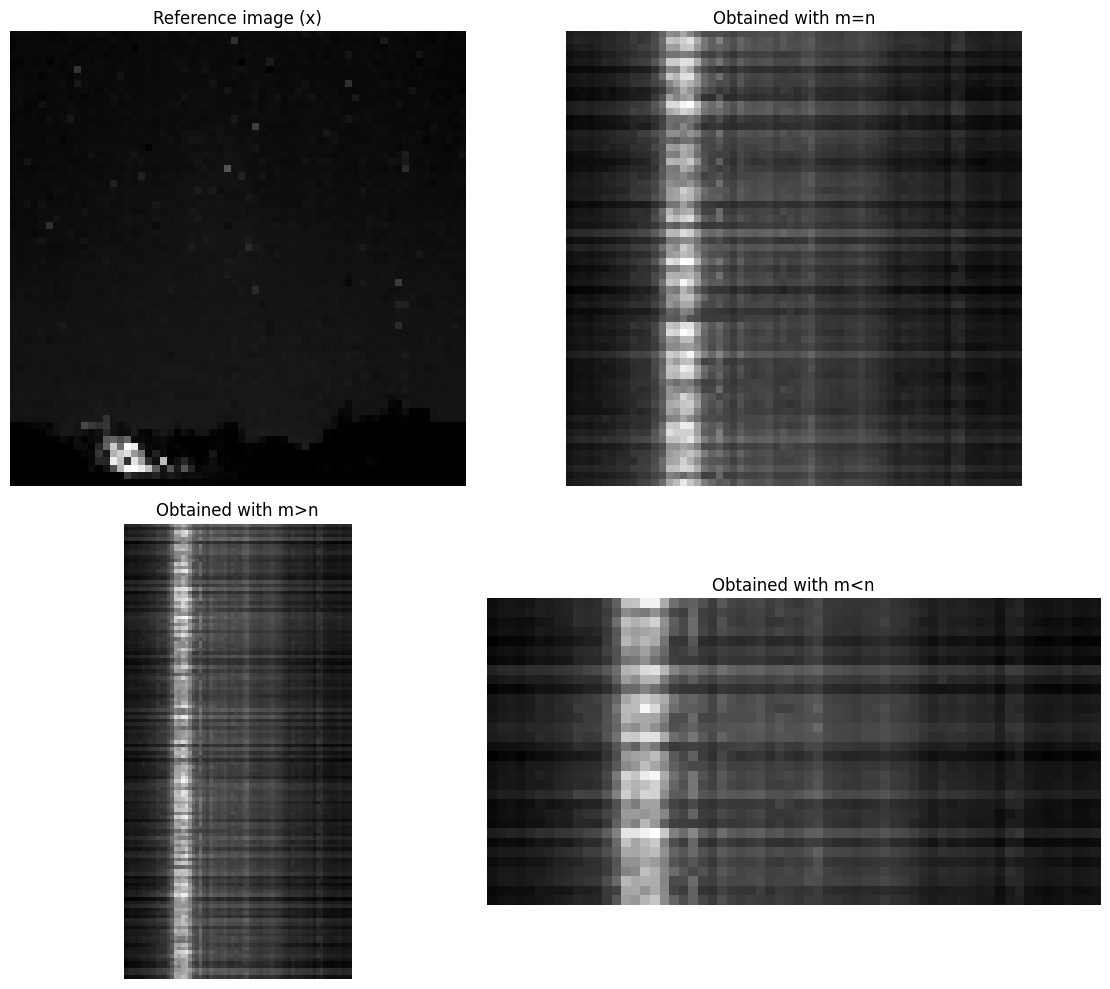

In [7]:
H_a = np.random.uniform(size=(64,64))
H_b = np.random.uniform(size=(128,64))
H_c = np.random.uniform(size=(32,64))

# m = n
y_a_noiseless = np.matmul(H_a, dark_sky_gray)
# m > n
y_b_noiseless = np.matmul(H_b, dark_sky_gray)
# m < n
y_c_noiseless = np.matmul(H_c, dark_sky_gray)

plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.imshow(dark_sky_gray, cmap='gray')
plt.axis('off')
plt.title('Reference image (x)')
plt.subplot(2, 2, 2)
plt.imshow(y_a_noiseless, cmap='gray')
plt.axis('off')
plt.title('Obtained with m=n')
plt.subplot(2, 2, 3)
plt.imshow(y_b_noiseless, cmap='gray')
plt.axis('off')
plt.title('Obtained with m>n')
plt.subplot(2, 2, 4)
plt.imshow(y_c_noiseless, cmap='gray')
plt.axis('off')
plt.title('Obtained with m<n')
plt.tight_layout()
plt.show()

In [8]:
#admm_alg(img, H, x_0, z_0, u_0, lamb=0.01, rho=1, steps=10):
x_a_hist, z_a_hist, u_a_hist = admm_alg(y_a_noiseless, H_a, 1, 0.1, 10)
x_b_hist, z_b_hist, u_b_hist = admm_alg(y_b_noiseless, H_b, 1, 0.1, 10)
x_c_hist, z_c_hist, u_c_hist = admm_alg(y_c_noiseless, H_c, 1, 0.1, 10)

The tolerance has reached in step 0
The tolerance has reached in step 0
The tolerance has reached in step 0


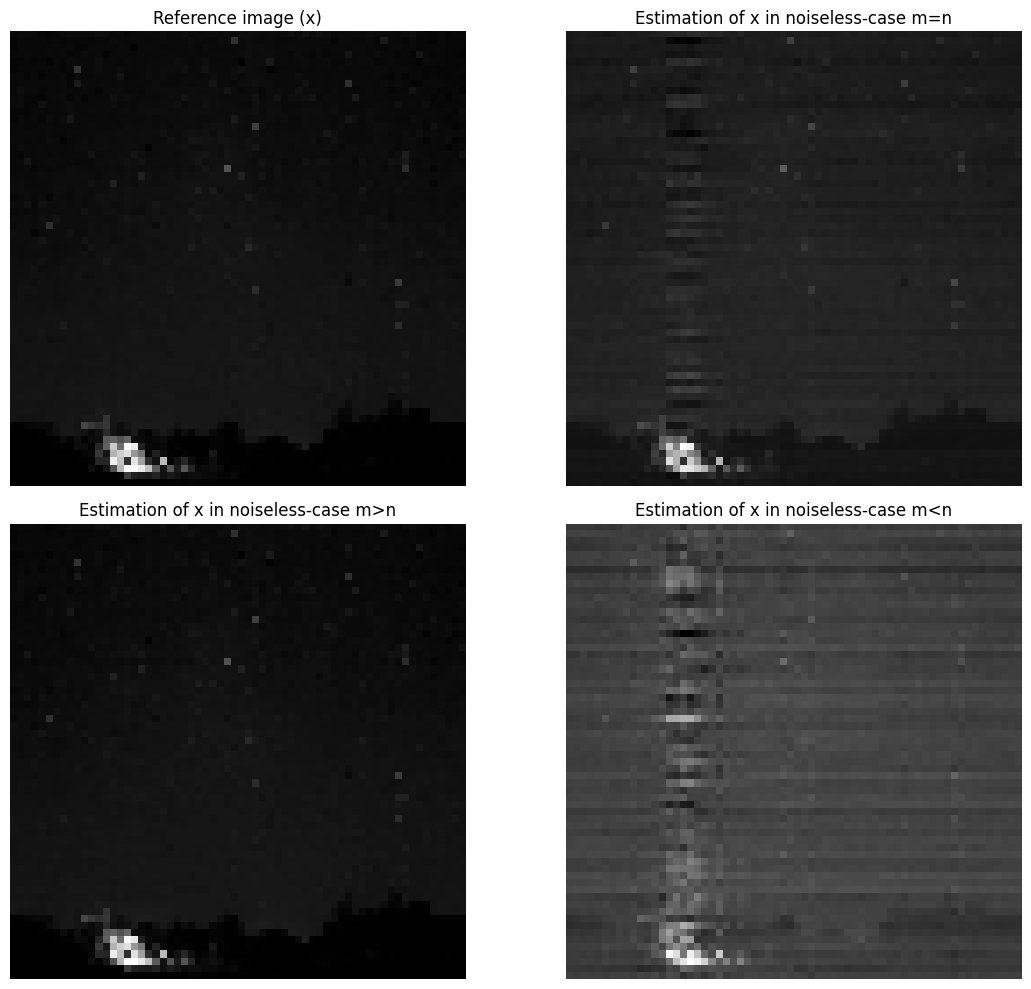

In [9]:
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.imshow(dark_sky_gray, cmap='gray')
plt.axis('off')
plt.title('Reference image (x)')
plt.subplot(2, 2, 2)
plt.imshow(x_a_hist[-1], cmap='gray')
plt.axis('off')
plt.title('Estimation of x in noiseless-case m=n')
plt.subplot(2, 2, 3)
plt.imshow(x_b_hist[-1], cmap='gray')
plt.axis('off')
plt.title('Estimation of x in noiseless-case m>n')
plt.subplot(2, 2, 4)
plt.imshow(x_c_hist[-1], cmap='gray')
plt.axis('off')
plt.title('Estimation of x in noiseless-case m<n')
plt.tight_layout()
plt.show()

### Noise case with 25dB of SNR

In this scenario, the model is:
$$
\mathbf{y} = \mathbf{Hx} + \epsilon
$$

In [10]:
def noise_25dB(H, image, noise_std):
    y = np.matmul(H, image)
    y = y + np.random.normal(0, noise_std, size=y.shape)
    return y

Define a function to compute the SNR for 25dB:
$$
\begin{alignat}{1}
SNR_{dB} &= 10 * \log_{10} \Bigg( \frac{P_{\text{signal}}}{P_{\text{noise}}} \Bigg) \\
25 &= 10 * \log_{10} \Bigg( \frac{P_{\text{signal}}}{P_{\text{noise}}} \Bigg) \\
2.5 &= \log_{10} \Bigg( \frac{P_{\text{signal}}}{P_{\text{noise}}} \Bigg) \\
10^{2.5} &=  \Bigg( \frac{P_{\text{signal}}}{P_{\text{noise}}} \Bigg) \\
P_{\text{noise}} &=  \Bigg( \frac{P_{\text{signal}}}{10^{2.5}} \Bigg) \\
\frac{1}{MN} \sum_{i = 0}^{MN} y_{mn}^2 &= \Bigg( \frac{P_{\text{signal}}}{10^{2.5}} \Bigg)
\end{alignat}
$$

In [11]:
def noise_gaussian(image, sigma=0.1):
    noise = np.random.normal(0, sigma, size=image.shape)
    return noise

def powers(signal):
    return np.mean(np.power(signal, 2))

In [12]:
def compute_sigma(signal):
    MIN_SD = 0.001
    MIN_DB = np.power(10, 2.5)

    p_signal = powers(signal)
    sd = MIN_SD
    while True:
        p_noise = powers(noise_gaussian(signal, sd))
        if MIN_DB < (p_signal / p_noise):
            print(f'The power of iteration is {p_noise}')
            break
        else:
            sd += .001
    return sd

In [13]:
sd_noise = compute_sigma(dark_sky_gray)

The power of iteration is 9.886290452187551e-07


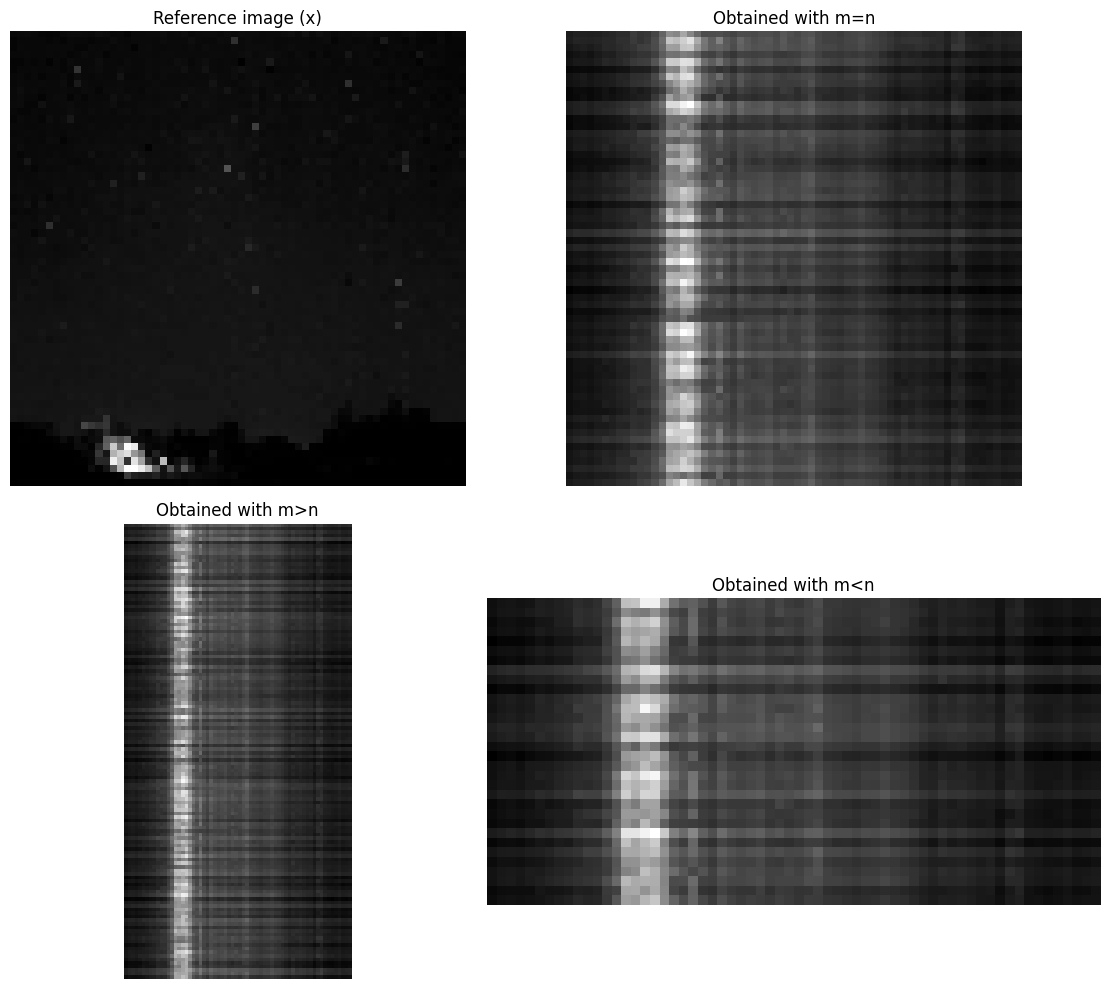

In [14]:
# m = n
y_d_noiseless = noise_25dB(H_a, dark_sky_gray, sd_noise)
# m > n
y_e_noiseless = noise_25dB(H_b, dark_sky_gray, sd_noise)
# m < n
y_f_noiseless = noise_25dB(H_c, dark_sky_gray, sd_noise)

plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.imshow(dark_sky_gray, cmap='gray')
plt.axis('off')
plt.title('Reference image (x)')
plt.subplot(2, 2, 2)
plt.imshow(y_d_noiseless, cmap='gray')
plt.axis('off')
plt.title('Obtained with m=n')
plt.subplot(2, 2, 3)
plt.imshow(y_e_noiseless, cmap='gray')
plt.axis('off')
plt.title('Obtained with m>n')
plt.subplot(2, 2, 4)
plt.imshow(y_f_noiseless, cmap='gray')
plt.axis('off')
plt.title('Obtained with m<n')
plt.tight_layout()
plt.show()

In [15]:
x_d_hist, z_d_hist, u_d_hist = admm_alg(y_d_noiseless, H_a, .1, 0.1, 10)
x_e_hist, z_e_hist, u_e_hist = admm_alg(y_e_noiseless, H_b, .1, 0.1, 10)
x_f_hist, z_f_hist, u_f_hist = admm_alg(y_f_noiseless, H_c, .1, 0.1, 10)

The tolerance has reached in step 0
The tolerance has reached in step 0
The tolerance has reached in step 0


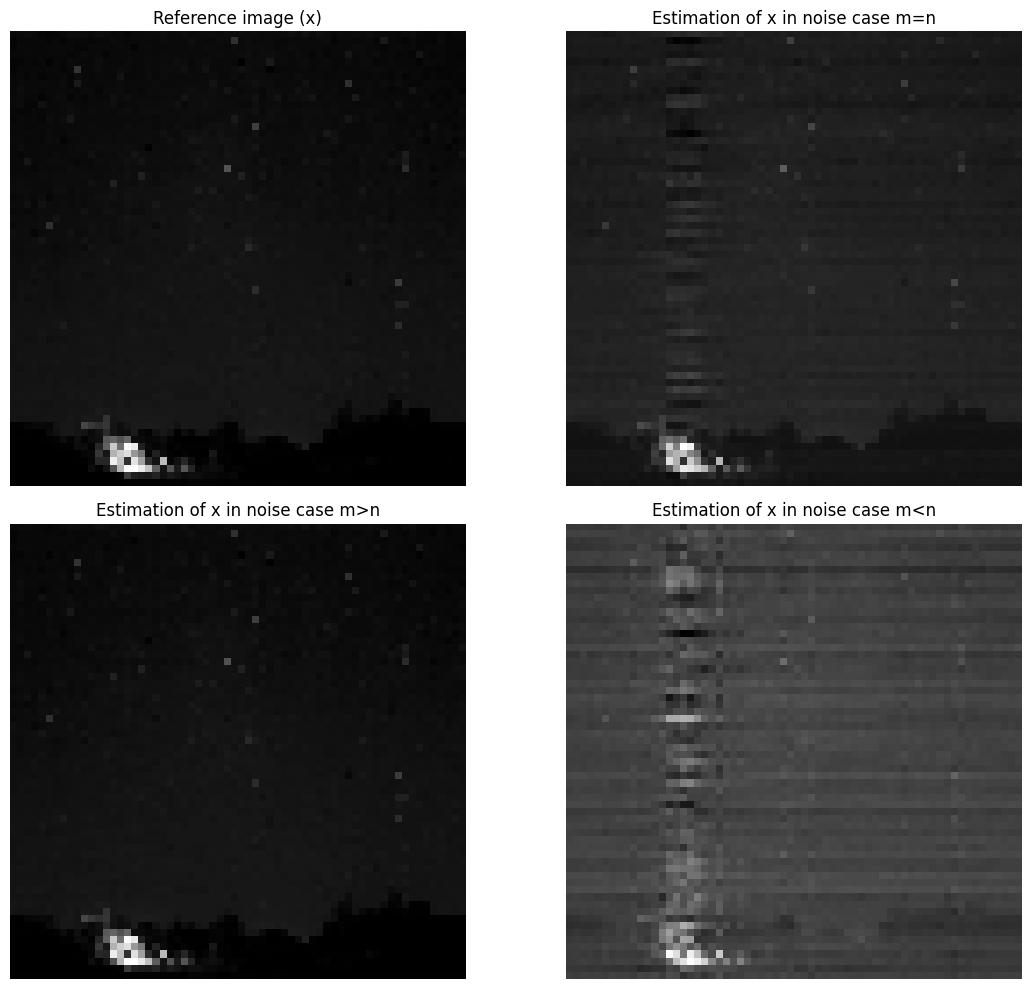

In [16]:
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.imshow(dark_sky_gray, cmap='gray')
plt.axis('off')
plt.title('Reference image (x)')
plt.subplot(2, 2, 2)
plt.imshow(x_d_hist[-1], cmap='gray')
plt.axis('off')
plt.title('Estimation of x in noise case m=n')
plt.subplot(2, 2, 3)
plt.imshow(x_e_hist[-1], cmap='gray')
plt.axis('off')
plt.title('Estimation of x in noise case m>n')
plt.subplot(2, 2, 4)
plt.imshow(x_f_hist[-1], cmap='gray')
plt.axis('off')
plt.title('Estimation of x in noise case m<n')
plt.tight_layout()
plt.show()